In [1]:
# Imports

from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [2]:
#######################################################
############### If using Google Drive #################
#######################################################

# Mount Google Drive where datasets are located
from google.colab import drive
drive.mount('/content/gdrive')

# Please note that if this cell does not run go to where the shared folder is on Google Drive, and
# right-click on the shared folder, and select Add shortcut to Drive. Then try execute the cell again.

# Change the current working directory
%cd /content/gdrive/MyDrive/DS\ Capstone\ Project/REPORT_CODE_STRUCTURED/data/

# Define data path
data_path = "processed/"

Mounted at /content/gdrive
/content/gdrive/MyDrive/DS Capstone Project/REPORT_CODE_STRUCTURED/data


In [3]:
#######################################################
############## If using Local Computer ################
#######################################################

# Define data path
data_path = "../data/processed/"

In [4]:
# Import cleaned data
df = pd.read_csv(f'{data_path}data_used_to_build_model.csv')

# Initialise processing method and functions

In [5]:
# Set whether using GPU / CPU to train models
#tree_method_setting = 'gpu_hist' # Using GPU
tree_method_setting = 'hist' # Not using GPU


# Define function to calc evaluation metrics
def calc_evaluation_metrics(y_pred, y, set_desc):
  # Evaluation metrics
  mse = mean_squared_error(y, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  accuracy = (1 - mape) * 100

  # Calculate and display accuracy
  print("=================================")
  print("Evaluation Metrics of " + set_desc)
  print("Mean Squared Error : {0:7.8f}".format(mse))
  print("Root Mean Squared Error : {0:7.8f}".format(rmse))
  print("Mean Absolute Error : {0:7.8f}".format(mae))
  print("Mean Absolute Percentage Error : {0:7.8f}".format(mape))
  print(f"R-Squared : {round(r2, 8)}%")
  print(f"Accuracy: {round(accuracy, 8)}%.")
  print("=================================")

  return mse, rmse, mae, mape, r2, accuracy

# Model Development (QLD Only)

This notebook used for developing and tuning XGBoost forecast model.

# Feature Engineering 1

## Dates and times and dhift target feature (total demand) 
- Features created to represent different components of date and time. 
- Shift target features so that each row is predicting demand in future. A shift was created to represent each of the six predictions i.e. six target features created.

In [6]:
# Select one state
df = df[df["REGIONID"] == "QLD"]
state="QLD"

df = df.drop(["REGIONID"], axis=1)

# convert to datetime
df["DATETIME"] = pd.to_datetime(df["DATETIME"])

# Create date features

df["Hour"] = df["DATETIME"].dt.hour
df["Day"] = df["DATETIME"].dt.dayofweek
df["Month"] = df["DATETIME"].dt.month
df["Year"] = df["DATETIME"].dt.year
df["Qtr"] = df["DATETIME"].dt.quarter
df["Dayofyear"] = df["DATETIME"].dt.dayofyear
df["Dayofmonth"] = df["DATETIME"].dt.day
df["Weekofyear"] = df["DATETIME"].dt.weekofyear
df["temp_date"] = df["DATETIME"].dt.strftime("%m-%d") # deleted later
df["temp_date2"] = df["DATETIME"].dt.strftime("%m-%d-%y") # deleted later

# Set datetime as index
df.index = df["DATETIME"]

#df = df.drop(["DATETIME"],axis=1)

# shift target features so that each row is predicting demand 30 mins in future
# Create feature to denote "Current Demand" at t=0
df["CURRENTDEMAND"] = df["TOTALDEMAND"]

# Shift by 30 mins
#df["TOTALDEMAND"] = df["TOTALDEMAND"].shift(-1)

df["TOTALDEMAND_30"] = df["CURRENTDEMAND"].shift(-1) # demand at t+30 mins
df["TOTALDEMAND_60"] = df["CURRENTDEMAND"].shift(-2) # demand at t+60 mins
df["TOTALDEMAND_90"] = df["CURRENTDEMAND"].shift(-3) # demand at t+90 mins
df["TOTALDEMAND_120"] = df["CURRENTDEMAND"].shift(-4) # demand at t+120 mins
df["TOTALDEMAND_150"] = df["CURRENTDEMAND"].shift(-5) # demand at t+150 mins
df["TOTALDEMAND_180"] = df["CURRENTDEMAND"].shift(-6) # demand at t+180 mins

# Drop last row with null (due to shift)
df = df.dropna()

df_backup = df
df.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,DATETIME,TEMPERATURE,TOTALDEMAND,Hour,Day,Month,Year,Qtr,Dayofyear,Dayofmonth,Weekofyear,temp_date,temp_date2,CURRENTDEMAND,TOTALDEMAND_30,TOTALDEMAND_60,TOTALDEMAND_90,TOTALDEMAND_120,TOTALDEMAND_150,TOTALDEMAND_180
DATETIME,,,,,,,,,,,,,,,,,,,,
2021-03-17 19:00:00,2021-03-17 19:00:00,20.1,7486.67,19,2,3,2021,1,76,17,11,03-17,03-17-21,7486.67,7327.30,7190.86,7086.78,6894.85,6651.18,6443.62
2021-03-17 19:30:00,2021-03-17 19:30:00,19.8,7327.30,19,2,3,2021,1,76,17,11,03-17,03-17-21,7327.30,7190.86,7086.78,6894.85,6651.18,6443.62,6264.63
2021-03-17 20:00:00,2021-03-17 20:00:00,19.8,7190.86,20,2,3,2021,1,76,17,11,03-17,03-17-21,7190.86,7086.78,6894.85,6651.18,6443.62,6264.63,6144.16
2021-03-17 20:30:00,2021-03-17 20:30:00,19.8,7086.78,20,2,3,2021,1,76,17,11,03-17,03-17-21,7086.78,6894.85,6651.18,6443.62,6264.63,6144.16,5897.64
2021-03-17 21:00:00,2021-03-17 21:00:00,19.8,6894.85,21,2,3,2021,1,76,17,11,03-17,03-17-21,6894.85,6651.18,6443.62,6264.63,6144.16,5897.64,5737.03


## Feature engineering 2
- Add dates of public holidays and flag for weekend. 
- Note that public holidays were not used in the final model since they did not improve performance.

In [ ]:
# add in features for weekends, holidays
# hard code in official QLD Public holidays 2016-2021
"""
def feature_holidays(row):
    if row["temp_date2"] == "01-01-16" or row["temp_date2"] == "02-01-17" or row["temp_date2"] == "01-01-18" or row["temp_date2"] == "01-01-19" or row["temp_date2"] == "01-01-20" or row["temp_date2"] == "01-01-21": # NYD
        return "pub_hol"
    if row["temp_date2"] == "26-01-16" or row["temp_date2"] == "26-01-17" or row["temp_date2"] == "26-01-18" or row["temp_date2"] == "26-01-19" or row["temp_date2"] == "27-01-20" or row["temp_date2"] == "26-01-21": # Aus day
        return "pub_hol"
    if row["temp_date2"] == "25-03-16" or row["temp_date2"] == "14-03-17" or row["temp_date2"] == "30-03-18" or row["temp_date2"] == "02-04-19" or row["temp_date2"] == "10-04-20" or row["temp_date2"] == "02-04-21": # Easter Fri
        return "pub_hol"
    if row["temp_date2"] == "28-03-16" or row["temp_date2"] == "17-03-17" or row["temp_date2"] == "02-04-18" or row["temp_date2"] == "05-04-19" or row["temp_date2"] == "13-04-20" or row["temp_date2"] == "05-04-21": # Easter Mon
        return "pub_hol"
    if row["temp_date2"] == "25-04-16" or row["temp_date2"] == "25-04-17" or row["temp_date2"] == "25-04-18" or row["temp_date2"] == "26-04-19" or row["temp_date2"] == "27-04-20" or row["temp_date2"] == "25-04-21": # Anzac Day
        return "pub_hol"
    if row["temp_date2"] == "02-05-16" or row["temp_date2"] == "01-05-17" or row["temp_date2"] == "07-05-18" or row["temp_date2"] == "03-05-19" or row["temp_date2"] == "04-05-20" or row["temp_date2"] == "03-05-21": # Labour Day
        return "pub_hol"
    if row["temp_date2"] == "03-10-16" or row["temp_date2"] == "02-10-17" or row["temp_date2"] == "01-10-18" or row["temp_date2"] == "04-10-19" or row["temp_date2"] == "05-10-20" or row["temp_date2"] == "04-10-21": # Queen's Birthday
        return "pub_hol"
    if row["temp_date2"] == "27-12-16" or row["temp_date2"] == "25-12-17" or row["temp_date2"] == "25-12-18" or row["temp_date2"] == "27-12-19" or row["temp_date2"] == "25-12-20" or row["temp_date2"] == "27-12-21": # Xmas day
        return "pub_hol"
    if row["temp_date2"] == "26-12-16" or row["temp_date2"] == "26-12-17" or row["temp_date2"] == "26-12-18" or row["temp_date2"] == "28-12-19" or row["temp_date2"] == "28-12-20" or row["temp_date2"] == "28-12-21": # Boxing Day
        return "pub_hol"
    if row["temp_date2"] == "24-12-19" or row["temp_date2"] == "24-12-20" or row["temp_date2"] == "24-12-21": # Xmas eve
        return "pub_hol"
    return 'Other'
 """

  # Create feature for weekend 
def feature_weekend(row):
    if row["Day"] == 5 or row["Day"] == 6:
        return "Weekend"
    return "NonWeekend"

# Apply feature eng
#df["Holiday"] = df.apply (lambda row : feature_holidays(row), axis=1)
df["Weekend"] = df.apply(lambda row: feature_weekend(row), axis=1)

# One-hot encode categorical fields
dummies = pd.get_dummies(df[["Weekend"]], prefix="is", drop_first=True)
df = df.join(dummies, lsuffix="_left")
df = df.drop(df[["Weekend"]], axis=1)

# drop temporary fields
df = df.drop(["temp_date"], axis=1)
df = df.drop(["temp_date2"], axis=1)

# Plot autocorrelation between temperature and demand
Done to investigate cyclicality of temperature and demand to inform the offset of lag variables that can be added to improve model performance

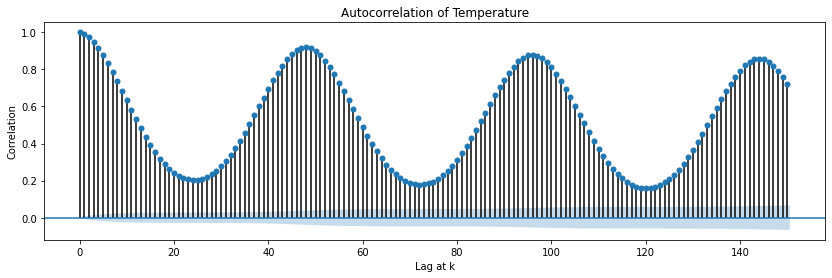

In [ ]:
# plot autocorrelation of temperature to determine values for lag features

from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams


rcParams["figure.figsize"] = 14, 4
fig = plot_acf(df["TEMPERATURE"], lags=150)

plt.title("Autocorrelation of Temperature")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
fig.show();

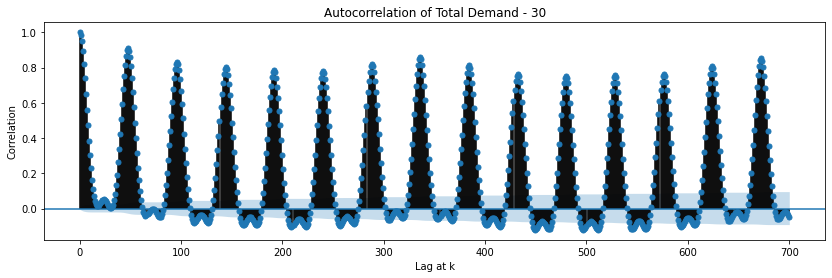

In [ ]:
# plot autocorrelation of demand to determine values for lag features

from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams


rcParams["figure.figsize"] = 14, 4
fig = plot_acf(df["TOTALDEMAND_30"], lags=700)

plt.title("Autocorrelation of Total Demand - 30")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
fig.show();

Strong autocorrelation at 1, 2, 3, 48

## Split into 3 dataframes for Training, Validation and Holdout tesing

In [ ]:
df.tail()

,DATETIME,TEMPERATURE,TOTALDEMAND,Hour,Day,Month,Year,Qtr,Dayofyear,Dayofmonth,Weekofyear,CURRENTDEMAND,TOTALDEMAND_30,TOTALDEMAND_60,TOTALDEMAND_90,TOTALDEMAND_120,TOTALDEMAND_150,TOTALDEMAND_180,is_Weekend
DATETIME,,,,,,,,,,,,,,,,,,,
2021-03-17 19:00:00,2021-03-17 19:00:00,20.1,7486.67,19,2,3,2021,1,76,17,11,7486.67,7327.30,7190.86,7086.78,6894.85,6651.18,6443.62,0
2021-03-17 19:30:00,2021-03-17 19:30:00,19.8,7327.30,19,2,3,2021,1,76,17,11,7327.30,7190.86,7086.78,6894.85,6651.18,6443.62,6264.63,0
2021-03-17 20:00:00,2021-03-17 20:00:00,19.8,7190.86,20,2,3,2021,1,76,17,11,7190.86,7086.78,6894.85,6651.18,6443.62,6264.63,6144.16,0
2021-03-17 20:30:00,2021-03-17 20:30:00,19.8,7086.78,20,2,3,2021,1,76,17,11,7086.78,6894.85,6651.18,6443.62,6264.63,6144.16,5897.64,0
2021-03-17 21:00:00,2021-03-17 21:00:00,19.8,6894.85,21,2,3,2021,1,76,17,11,6894.85,6651.18,6443.62,6264.63,6144.16,5897.64,5737.03,0


In [ ]:
# Define model start time and train/test cutoff time
model_start_time = '2016-01-01 00:00:00'
trainTestSplit = '2020-01-01 00:00:00'

# Discard all rows with DATETIME before 'model_start_time' - earlier dates are not an accurate representation of later dates (need plot)
df = df[df['DATETIME'] >= model_start_time] # only 2.9MB using 2016-01-01 00:00:00 model_start_time

# We also make a further 3 DataFrames for CV
### First we define the endtimes for train/val/test splits
train_end_1618, val_end_1618, test_end_1618 = '2016-12-31 23:30:00', '2017-12-31 23:30:00', '2018-12-31 23:30:00'
train_end_1619, val_end_1619, test_end_1619 = '2017-12-31 23:30:00', '2018-12-31 23:30:00', '2019-12-31 23:30:00'
train_end_1620, val_end_1620, test_end_1620 = '2018-12-31 23:30:00', '2019-12-31 23:30:00', '2020-12-31 23:30:00'

#train_end_1620, val_end_1620, test_end_1620 = '2018-12-31 23:30:00', '2019-12-31 23:30:00', '2021-03-18 00:00:00'# not using due to inconsistent holdout set length
### Define the 3 CV DataFrames
df_1618 = df.loc[(model_start_time <= df['DATETIME']) & (df['DATETIME'] <= test_end_1618), :].copy()
df_1619 = df.loc[(model_start_time <= df['DATETIME']) & (df['DATETIME'] <= test_end_1619), :].copy()
df_1620 = df.loc[(model_start_time <= df['DATETIME']) & (df['DATETIME'] <= test_end_1620), :].copy()

# Create a copy
df2 = df.copy()
df2.index = df2['DATETIME']

# Split into train test based ib "train end" val defined above

# Split into train and test based on arbitrary date in 2020 - this will be tested for different possibilities

# 16-18 period
df_train_1618 = df_1618[df_1618["DATETIME"]  <= train_end_1618].copy()
df_test_1618 = df_1618[(df_1618["DATETIME"] > train_end_1618) & (df_1618["DATETIME"] <= val_end_1618)].copy()
df_holdout_1618 = df_1618[(df_1618["DATETIME"] > val_end_1618) & (df_1618["DATETIME"] <= test_end_1618)].copy()

# 16-19 period
df_train_1619 = df_1619[df_1619["DATETIME"] <= train_end_1619].copy()
df_test_1619 = df_1619[(df_1619["DATETIME"] > train_end_1619) & (df_1619["DATETIME"] <= val_end_1619) ].copy()
df_holdout_1619 = df_1619[(df_1619["DATETIME"] > val_end_1619) & (df_1619["DATETIME"] <= test_end_1619)].copy()

# 16-20 period
df_train_1620 = df_1620[df_1620["DATETIME"] <= train_end_1620].copy()
df_test_1620 = df_1620[(df_1620["DATETIME"] > train_end_1620) & (df_1620["DATETIME"] <= val_end_1620)].copy()
df_holdout_1620 = df_1620[(df_1620["DATETIME"] > val_end_1620) & (df_1620["DATETIME"] <= test_end_1620)].copy()

In [ ]:
# Alternative final evaluation sets( not used in analysis but a production model should be trained on the latest data possible)
train_end_1621, val_end_1621, test_end_1621 = '2018-12-31 23:30:00', '2019-03-17 23:30:00', '2020-03-17 23:30:00'
train_end_1622, val_end_1622, test_end_1622 = '2018-12-31 23:30:00', '2019-09-17 23:30:00', '2020-03-17 23:30:00'

df_1621 = df.loc[(model_start_time <= df['DATETIME']) & (df['DATETIME'] <= test_end_1621), :].copy()
df_1622 = df.loc[(model_start_time <= df['DATETIME']) & (df['DATETIME'] <= test_end_1622), :].copy()

# 16-21 period with latest data
df_train_1621 = df_1621[df_1621["DATETIME"] <= train_end_1621].copy()
df_test_1621 = df_1621[(df_1621["DATETIME"] > train_end_1621) & (df_1621["DATETIME"] <= val_end_1621)].copy()
df_holdout_1621 = df_1621[(df_1621["DATETIME"] > val_end_1621) & (df_1621["DATETIME"] <= test_end_1621)].copy()

# 16-21 period with latest data and only 6 month test set
df_train_1622 = df_1622[df_1622["DATETIME"] <= train_end_1622].copy()
df_test_1622 = df_1622[(df_1622["DATETIME"] > train_end_1622) & (df_1622["DATETIME"] <= val_end_1622)].copy()
df_holdout_1622 = df_1622[(df_1622["DATETIME"] > val_end_1622) & (df_1622["DATETIME"] <= test_end_1622)].copy()

# Feature engineering 3
- Add lag features based on time offsets discovered from autocorrelation plots
- Lag of current demand added for time offsets 1, 2, 3, 8, 21, 43, 331
- Rolling mean, min and max added for time offset 8
- This is done after train test split to avoid contaminating training data with actual values from validation and holdout data.

In [ ]:
# Lag and rolling features of Current energy demand
def lag_features(lagset, periods):
    temp_data = lagset["CURRENTDEMAND"]
    for period in periods:
        lagset["CURRENTDEMAND_lag_{}".format(period)] = temp_data.shift(period)
    for column in lagset.columns[20:]:
        # Fill now missing values (arising from shift) with mean for that hour.
        lagset[column] = lagset[column].fillna(lagset.groupby("Hour")["CURRENTDEMAND"].transform("mean"))
    return lagset

def apply_lag_features(df_train, df_test, df_holdout, lag_periods):
  df_train = lag_features(df_train, lag_periods)
  df_test = lag_features(df_test, lag_periods)
  df_holdout = lag_features(df_holdout, lag_periods)
  return df_train, df_test, df_holdout

# Rolling features of current energy demand
def rolling_features(lagset, periods):
    temp_data = lagset["CURRENTDEMAND"]
    for period in periods:
        lagset["CURRENTDEMAND_mean_rolling_{}".format(period)] = temp_data.rolling(period).mean()
        lagset["CURRENTDEMAND_max_rolling_{}".format(period)] = temp_data.rolling(period).max()
        lagset["CURRENTDEMAND_min_rolling_{}".format(period)] = temp_data.rolling(period).min()
    for column in lagset.columns[20:]:
        # Fill now missing values (arising from shift) with mean for that hour.
        lagset[column] = lagset[column].fillna(lagset.groupby("Hour")["CURRENTDEMAND"].transform("mean"))
    return lagset

def apply_rolling_features(df_train, df_test, df_holdout, rolling_periods):
  df_train = rolling_features(df_train, rolling_periods)
  df_test = rolling_features(df_test, rolling_periods)
  df_holdout = rolling_features(df_holdout, rolling_periods)
  return df_train, df_test, df_holdout

# 336 periods = previous week
# 96 periods = 2 days ago same hour
# 144 periods = 3 days ago same hour

# Apply lag features to all datasets
lag_periods = [1, 2, 3, 8, 21, 43, 331]

df_train_1618, df_test_1618, df_holdout_1618 = apply_lag_features(df_train_1618, df_test_1618, df_holdout_1618, lag_periods)
df_train_1619, df_test_1619, df_holdout_1619 = apply_lag_features(df_train_1619, df_test_1619, df_holdout_1619, lag_periods)
df_train_1620, df_test_1620, df_holdout_1620 = apply_lag_features(df_train_1620, df_test_1620, df_holdout_1620, lag_periods)

# Apply rolling features to all datasets
rolling_periods = [8]

df_train_1618, df_test_1618, df_holdout_1618 = apply_rolling_features(df_train_1618, df_test_1618, df_holdout_1618, rolling_periods)
df_train_1619, df_test_1619, df_holdout_1619 = apply_rolling_features(df_train_1619, df_test_1619, df_holdout_1619, rolling_periods)
df_train_1620, df_test_1620, df_holdout_1620 = apply_rolling_features(df_train_1620, df_test_1620, df_holdout_1620, rolling_periods)

In [ ]:
# 16-21 period with latest data
df_train_1621, df_test_1621, df_holdout_1621 = apply_lag_features(df_train_1621, df_test_1621, df_holdout_1621, lag_periods)
df_train_1622, df_test_1622, df_holdout_1622 = apply_lag_features(df_train_1622, df_test_1622, df_holdout_1622, lag_periods)

# Apply rolling features to alternative / additional datasets
rolling_periods = [8]

df_train_1621, df_test_1621, df_holdout_1621 = apply_rolling_features(df_train_1621, df_test_1621, df_holdout_1621, rolling_periods)
df_train_1622, df_test_1622, df_holdout_1622 = apply_rolling_features(df_train_1622, df_test_1622, df_holdout_1622, rolling_periods)

# Plot correlations between features#
- The correlation plot allows us to see which features have a correlation with the indempendent variable "TOTALDEMAND" (You can disregard the shifted iterations of this feature)
- The heatmap displays correlations between all features. It is useful to identify patterns in the data, as well as redundant features so that they can be removed. Redundant features can lead to poor performance and also increases the dimesnionality of the dataset with little gain.

Correlation bar-plot saved as: feature_correlations.png.
Correlation heatmap saved as: feature_heatmap.png.


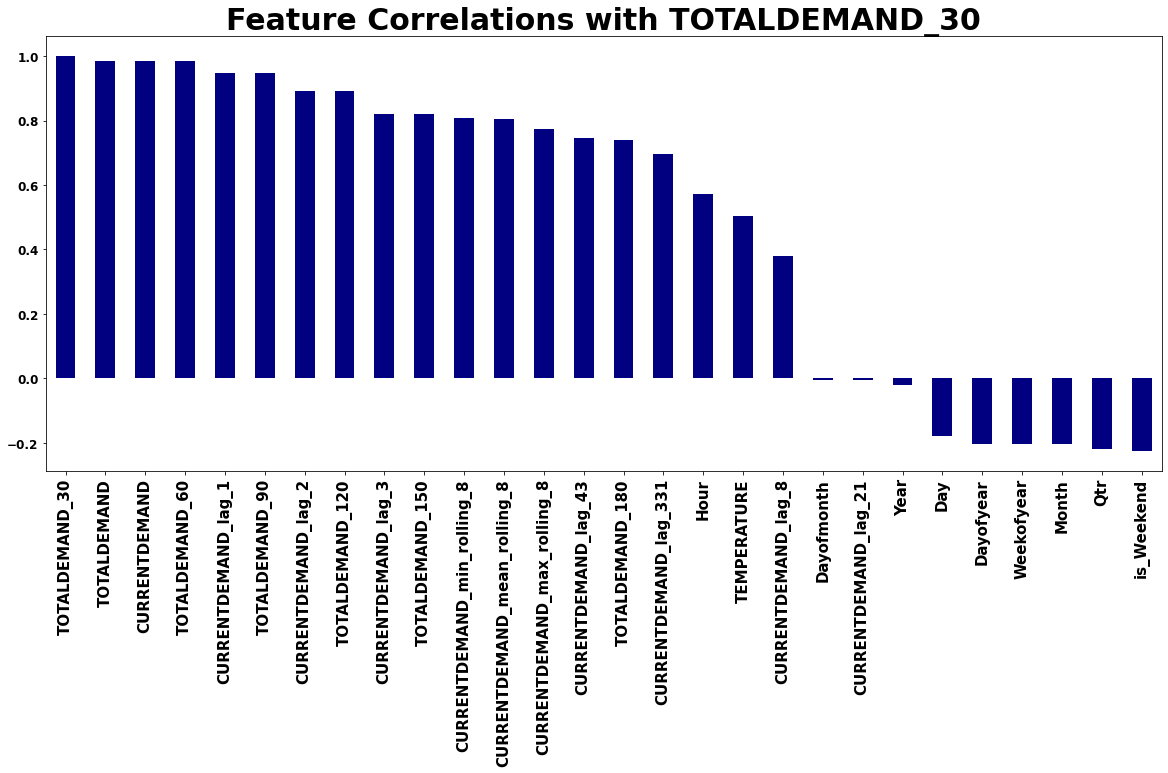

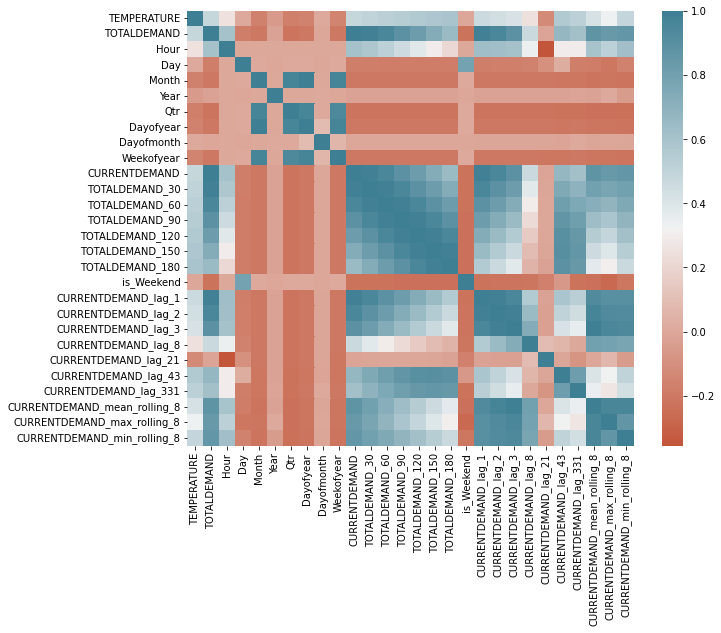

In [ ]:
# Plot correlations between our features and our target feature, totaldemand, as a bar plot, sort by descending order

# Nominate dataframe to be used for visualisation:
# 16-20 period
demand_train = df_train_1620
demand_test = df_test_1620

# Corralation Bar chart
plot_title = "Feature Correlations with TOTALDEMAND_30"
df_train_1620.corr()["TOTALDEMAND_30"].sort_values(ascending = False).plot.bar(figsize = (20, 8), color = 'Navy')
plt.title(plot_title, fontsize = 30, fontweight = 'bold')
plt.xticks(fontsize = 15, fontweight = 'bold')
plt.yticks(fontweight = 'bold', fontsize = 12)
plt.savefig('feature_correlations.png')
#plt.tight_layout()
print("Correlation bar-plot saved as: feature_correlations.png.")

# Generate heatmap of features
plt.figure(figsize = (10, 8))
sns.heatmap(df_train_1620.corr(), cmap = sns.diverging_palette(20, 220, n=256))
plt.savefig('feature_heatmap.png')
print("Correlation heatmap saved as: feature_heatmap.png.")

# Plot train test split
- We can now visualise the training and test (aka valiadation) sets for the three time-series cross-validation folds.

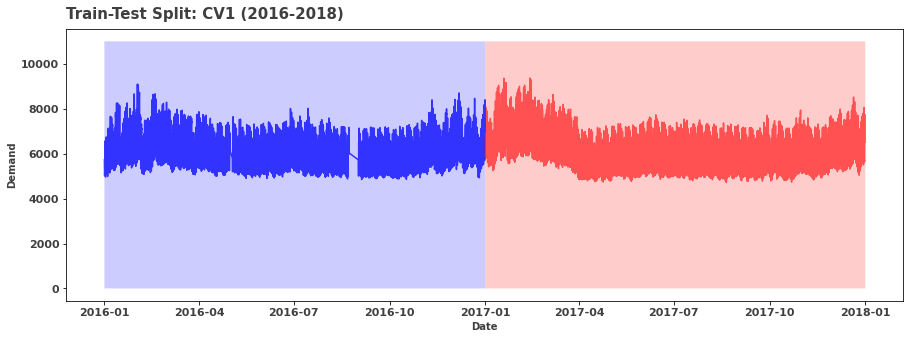

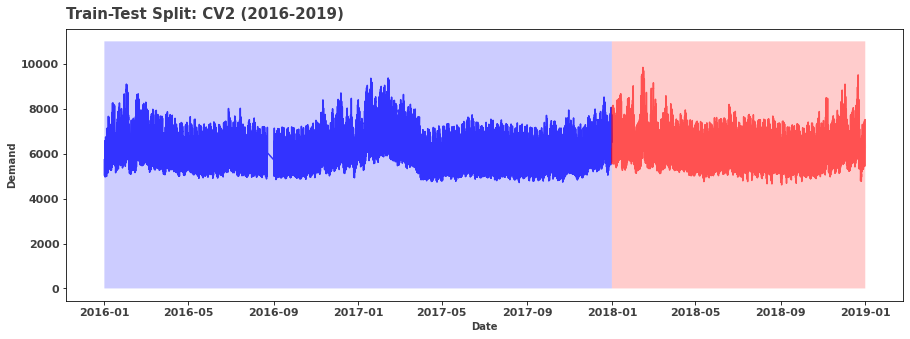

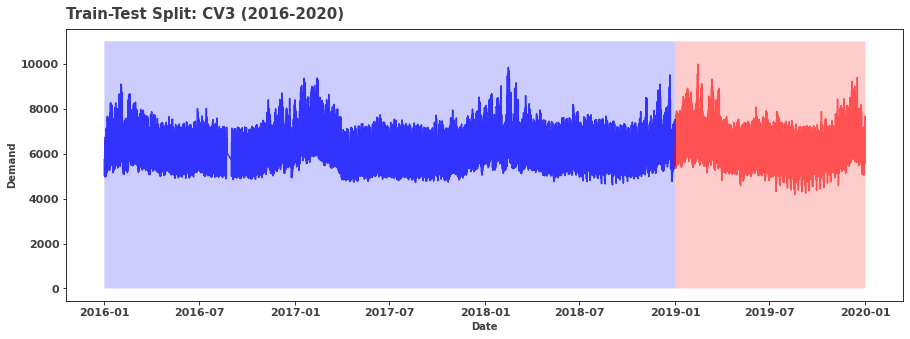

In [ ]:
# Plot train test split

def plot_train_test_split(train, test, title):
  fig,ax = plt.subplots(figsize=(15,5))
  coloring = 11000
  plt.plot(train.index, train["TOTALDEMAND"],color="blue", alpha=0.75)
  plt.fill_between(train.index,coloring, facecolor="blue", alpha=0.2)

  plt.plot(test.index, test["TOTALDEMAND"], color = "red", alpha=0.60)
  plt.fill_between(test.index,coloring, facecolor="red", alpha=0.2)

  plt.xlabel("Date", alpha=0.75, weight="bold")
  plt.ylabel("Demand", alpha=0.75, weight="bold")
  plt.xticks(alpha=0.75,weight="bold", fontsize=11)
  plt.yticks(alpha=0.75,weight="bold", fontsize=11)
  plt.title(title, alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

plot_train_test_split(df_train_1618, df_test_1618, "Train-Test Split: CV1 (2016-2018)") # 16-18
plot_train_test_split(df_train_1619, df_test_1619, "Train-Test Split: CV2 (2016-2019)") # 16-19
plot_train_test_split(df_train_1620, df_test_1620, "Train-Test Split: CV3 (2016-2020)") # 16-20

# Drop unnecessary cols in preparation for input to model
def drop_unnecessary_cols(df_train, df_test, df_holdout):
  df_train = df_train.drop(["DATETIME"], axis=1)
  df_test = df_test.drop(["DATETIME"], axis=1)
  df_holdout = df_holdout.drop(["DATETIME"], axis=1)
  return df_train, df_test, df_holdout

df_train_1618, df_test_1618, df_holdout_1618 = drop_unnecessary_cols(df_train_1618, df_test_1618, df_holdout_1618)
df_train_1619, df_test_1619, df_holdout_1619 = drop_unnecessary_cols(df_train_1619, df_test_1619, df_holdout_1619)
df_train_1620, df_test_1620, df_holdout_1620 = drop_unnecessary_cols(df_train_1620, df_test_1620, df_holdout_1620)

In [ ]:
df_train_1621, df_test_1621, df_holdout_1621 = drop_unnecessary_cols(df_train_1621, df_test_1621, df_holdout_1621)

# XGBoost Baseline Model

The first step is to train a baseline model with default hyperparameters.
This model will be a multi-output model as it is predicting multiple timesteps in advance. We will improve upon this model with tuning etc.

## Prepare data for passing to model
Here we specify which columns in the dataframes will be used as featureas and which will be targets.
- We must be careful that the training data does not become contaminated with the targets! This would yield an unrealistically high performing model that is using data 'from the future' i.e. impossible in real-time forecasting.
- X are the features so we must make sure to drop the "TOTALDEMAND" variables from this dataframe as these correspond to the six target variables for our predictions
y are the targets i.e. the columns mentioned above


In [ ]:
def prepare_Xy(df):
  # Feature frame (Drop demand column) and Target frame (only demand column)
  X = df.drop(["TOTALDEMAND", "TOTALDEMAND_30", "TOTALDEMAND_60", "TOTALDEMAND_90", "TOTALDEMAND_120", "TOTALDEMAND_150", "TOTALDEMAND_180"], axis=1)
  y = df[["TOTALDEMAND_30", "TOTALDEMAND_60", "TOTALDEMAND_90", "TOTALDEMAND_120", "TOTALDEMAND_150", "TOTALDEMAND_180"]]
  return X, y

# Set up train and test sets
X_train, y_train = prepare_Xy(df_train_1620)
X_test, y_test = prepare_Xy(df_test_1620)

## Preview the data to make sure we know what we are getting:
Looks like all our required variables are there. If we're happy then we can start building our model.


In [ ]:
X_train.head()

,TEMPERATURE,Hour,Day,Month,Year,Qtr,Dayofyear,Dayofmonth,Weekofyear,CURRENTDEMAND,is_Weekend,CURRENTDEMAND_lag_1,CURRENTDEMAND_lag_2,CURRENTDEMAND_lag_3,CURRENTDEMAND_lag_8,CURRENTDEMAND_lag_21,CURRENTDEMAND_lag_43,CURRENTDEMAND_lag_331,CURRENTDEMAND_mean_rolling_8,CURRENTDEMAND_max_rolling_8,CURRENTDEMAND_min_rolling_8
DATETIME,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,19.4,0,4,1,2016,1,1,1,53,5730.86,0,NaN,5727.038465,5727.038465,5727.038465,5727.038465,5727.038465,5727.038465,5727.038465,5727.038465,5727.038465
2016-01-01 00:30:00,19.8,0,4,1,2016,1,1,1,53,5563.19,0,5730.86,5727.038465,5727.038465,5727.038465,5727.038465,5727.038465,5727.038465,5727.038465,5727.038465,5727.038465
2016-01-01 01:00:00,19.3,1,4,1,2016,1,1,1,53,5467.18,0,5563.19,5730.860000,5440.512433,5440.512433,5440.512433,5440.512433,5440.512433,5440.512433,5440.512433,5440.512433
2016-01-01 01:30:00,18.5,1,4,1,2016,1,1,1,53,5296.78,0,5467.18,5563.190000,5730.860000,5440.512433,5440.512433,5440.512433,5440.512433,5440.512433,5440.512433,5440.512433
2016-01-01 02:00:00,18.3,2,4,1,2016,1,1,1,53,5240.83,0,5296.78,5467.180000,5563.190000,5283.552253,5283.552253,5283.552253,5283.552253,5283.552253,5283.552253,5283.552253


In [ ]:
y_train.head()

,TOTALDEMAND_30,TOTALDEMAND_60,TOTALDEMAND_90,TOTALDEMAND_120,TOTALDEMAND_150,TOTALDEMAND_180
DATETIME,,,,,,
2016-01-01 00:00:00,5563.19,5467.18,5296.78,5240.83,5183.29,5127.46
2016-01-01 00:30:00,5467.18,5296.78,5240.83,5183.29,5127.46,5091.68
2016-01-01 01:00:00,5296.78,5240.83,5183.29,5127.46,5091.68,5049.64
2016-01-01 01:30:00,5240.83,5183.29,5127.46,5091.68,5049.64,5057.78
2016-01-01 02:00:00,5183.29,5127.46,5091.68,5049.64,5057.78,5052.75


## Define base model
here we define the base model. 
- Since we are using a multi output regression model, we will use the "MultiOutputRegressor" class from sklearn. This acts as a wrapper for out XGBoost model and trains an instance on each of the target columns. 
- It behaves like a normal sklearn model class so we can call the .fit() and .predict() functions on it.
- In essence there will be six XGBoost models working together to provide predictions - one for each of our timesteps.

Once we fit the model we can make some predictions on our triaining (or validation) set and calculate some error metrics to see how good our model is.

In [ ]:
# Base model XGB

# multi output regression using single XGB Regressor
XGB_multi_base = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=1000, tree_method=tree_method_setting)) 
XGB_multi_base.fit(X_train, y_train, eval_metric="rmse")

# make predictions on test set
y_pred = XGB_multi_base.predict(X_test)

# print evaluation metrics metrics
calc_evaluation_metrics(y_pred, y_test, "Test Set")

[09:49:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:49:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Evaluation Metrics of Test Set
Mean Squared Error : 16465.25899429
Root Mean Squared Error : 128.31702535
Mean Absolute Error : 88.67400271
Mean Absolute Percentage Error : 0.01442297
R-Squared : 0.97940862%
Accuracy: 98.55770333%.


(16465.258994289958,
 128.31702534850922,
 88.67400270988662,
 0.01442296671945451,
 0.9794086158920828,
 98.55770332805454)

- Note that the metrics on the base model are quite good (although we can't be sure until we have a baseline to compare it to). 
- This performance is likely due to the feature engineering and selection which was performed. This was quite a long process of trial and error, however makes a really big difference in producing a good model. 

## Feature importance
- Speaking of feature engineering, a useful tool for this is feature importance plots. Now that we have a base model, we can use it to produce feature importance plots as below to know which features are related to the target the most closely. Note that there are three different examples of how 'importance' can be calculated - "weight", "gain" and "cover"
 - Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model
 - Coverage means the relative number of observations related to this feature.
 - Weight is the percentage representing the relative number of times a particular feature occurs in the trees of the model.

Since we are using a multi output regressor, we must access the feature importances of each of the estimators contained within.

['TEMPERATURE', 'Hour', 'Day', 'Month', 'Year', 'Qtr', 'Dayofyear', 'Dayofmonth', 'Weekofyear', 'CURRENTDEMAND', 'is_Weekend', 'CURRENTDEMAND_lag_1', 'CURRENTDEMAND_lag_2', 'CURRENTDEMAND_lag_3', 'CURRENTDEMAND_lag_8', 'CURRENTDEMAND_lag_21', 'CURRENTDEMAND_lag_43', 'CURRENTDEMAND_lag_331', 'CURRENTDEMAND_mean_rolling_8', 'CURRENTDEMAND_max_rolling_8', 'CURRENTDEMAND_min_rolling_8']
XGBRegressor(n_estimators=1000, tree_method='hist')
Weight
XGBRegressor(n_estimators=1000, tree_method='hist')
Weight
XGBRegressor(n_estimators=1000, tree_method='hist')
Weight
XGBRegressor(n_estimators=1000, tree_method='hist')
Weight
XGBRegressor(n_estimators=1000, tree_method='hist')
Weight
XGBRegressor(n_estimators=1000, tree_method='hist')
Weight


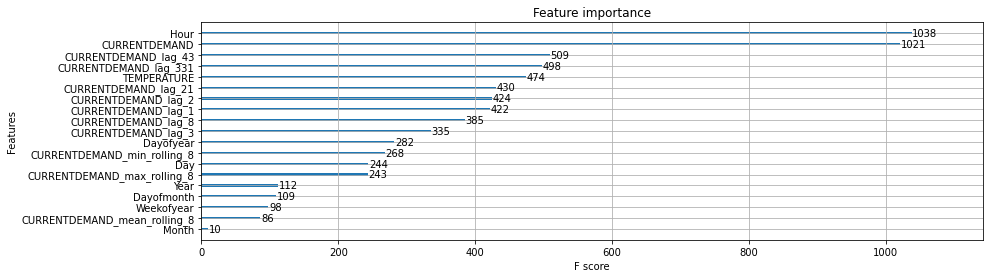

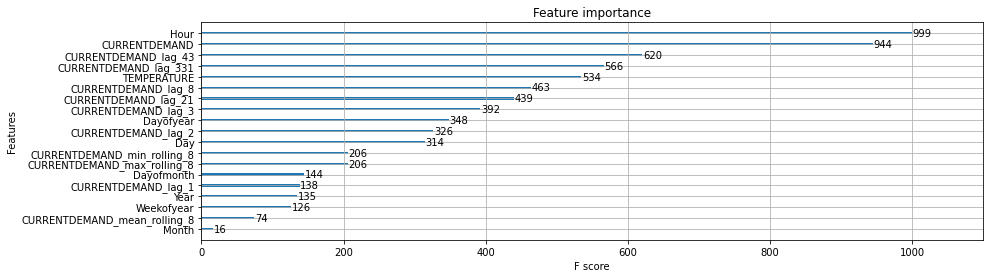

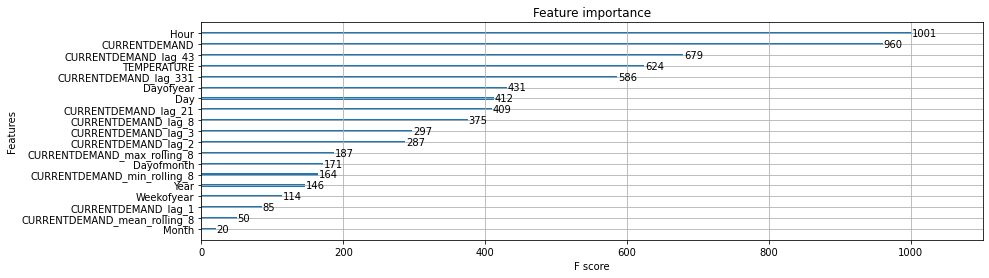

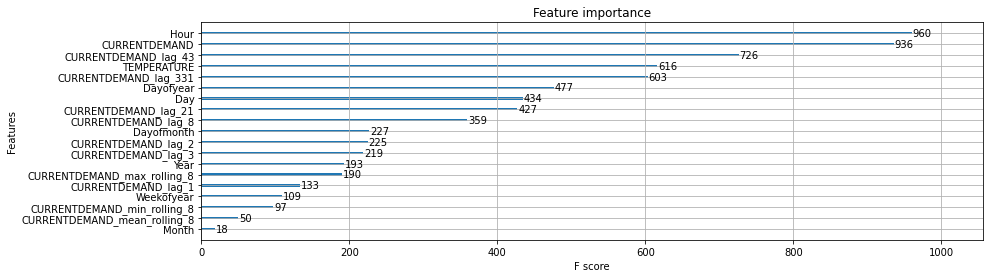

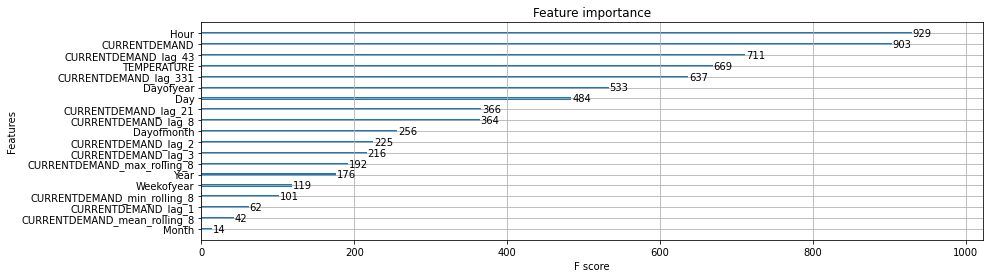

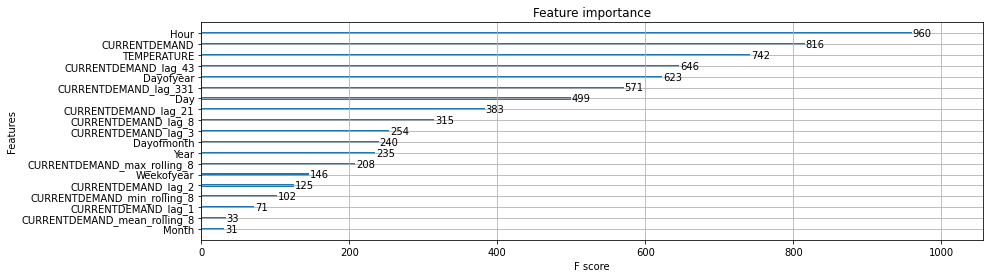

In [ ]:
# Get average feature importances:
# get cols names
colnames = list(X_train)
print(colnames)

# Access feature importances of models within multi regressor:
for model in XGB_multi_base.estimators_:
  print(model)
  print("Weight")
  plot_importance(model, importance_type="weight")
  #print("Gain")
  #plot_importance(model, importance_type="gain")
  #print("Cover")
  #plot_importance(model, importance_type="cover")


# Tune XGB Hyperparameters
Now that we have our baseline model, we can tune the hyperparameters to increase model performance. We can do this by searching the possible parameter space for the values that will yield the best performance on the test(validation) set. Since XGBoost has quite a few parameters, we will be using the Hyperopt library instead of a grid search. This method uses a more sophisticated algorithm to search the parameter space and will be more efficient. 
- That being said, this step of the process still takes a long time, so don't run the below cells if you don't have the time!

In [ ]:
# Set up parameter tuning for multi-regressor
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 42
    }

def objective(space):
    XGB_Reg2=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    XGB_multi2 = MultiOutputRegressor(XGB_Reg2)
  
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    XGB_multi2.fit(X_train, y_train)

    return {'loss': -rmse, 'status': STATUS_OK }

In [ ]:
# Set up train and test sets
X_train, y_train = prepare_Xy(df_train_1620)
X_test, y_test = prepare_Xy(df_test_1620)


# CAREFUL - below takes long time to run!
# Run hyperparameter optimisation using Hypropt

"""
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print(best_hyperparams)"""

'\ntrials = Trials()\nbest_hyperparams = fmin(fn = objective,\n                        space = space,\n                        algo = tpe.suggest,\n                        max_evals = 100,\n                        trials = trials)\n\nprint(best_hyperparams)'

# Run model for all three CV sets and calculate evaluation metrics:

Now that we have our hyperparameters, we can train an enhanced model. Here we can play with the n_estimators parameter to make sure the model is not overfitting. This is necessary because the MultiOutputRegressor object unfortunately does not support automatic early stopping (one of the great features of XGBoost!)

In [ ]:
# Some other model settings (not being used currently):
"""
# tuned for all features
XGB_Reg = xgb.XGBRegressor(n_estimators=1000,
                           colsample_bytree = 0.8475880225837492, 
                           gamma = 6.55325009549269, 
                           max_depth = 18,
                           min_child_weight = 3, 
                           reg_alpha = 44,
                           reg_lambda = 0.11839985834236118, 
                           seed=42)"""
"""
# tuned for feature selected params
XGB_Reg = xgb.XGBRegressor(n_estimators=1000,
                           colsample_bytree = 0.9223244113765763, 
                           gamma = 1.2743635903716086, 
                           max_depth = 14,
                           min_child_weight = 9, 
                           reg_alpha = 86,
                           reg_lambda = 0.12419884176179763, 
                           seed=42)
"""

'\n# tuned for feature selected params\nXGB_Reg = xgb.XGBRegressor(n_estimators=1000,\n                           colsample_bytree = 0.9223244113765763, \n                           gamma = 1.2743635903716086, \n                           max_depth = 14,\n                           min_child_weight = 9, \n                           reg_alpha = 86,\n                           reg_lambda = 0.12419884176179763, \n                           seed=42)\n'

# Initialise final model

In [ ]:
# Model settings:

# Final hyperparams tuned on feaure engineered data 180 estimators 
# {'colsample_bytree': 0.7980169531492971, 'gamma': 2.8712586599888503, 'max_depth': 5.0, 'min_child_weight': 4.0, 'reg_alpha': 177.0, 'reg_lambda': 0.022218633053579184}

# tuned for all params (multi regressor)
# These parameters yielded the best model!
XGB_Reg_tuned = xgb.XGBRegressor(n_estimators=1000,
                           colsample_bytree = 0.7980169531492971, 
                           gamma = 2.8712586599888503, 
                           max_depth = 5,
                           min_child_weight = 4, 
                           reg_alpha = 177,
                           reg_lambda = 0.022218633053579184, 
                           seed=42, tree_method=tree_method_setting)                   

In [ ]:
# Define function to train model on one fold and calculate required evaluation metrics
def train_cv(reg_multi, df_train, df_test, verb):

  # Set up features and target
  X_train, y_train = prepare_Xy(df_train)
  X_test,  y_test = prepare_Xy(df_test)

  # fit multi output regressor
  reg_multi.fit(X_train, y_train)

  # make predictions on test set
  y_pred = reg_multi.predict(X_test)

  # calculate evaluation metrics
  mse, rmse, mae, mape, r2, acc = calc_evaluation_metrics(y_pred, y_test, "Test Set")
  d = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R-Squared': r2, 'Accuracy': acc}
  metrics = pd.Series(data=d)

  return reg_multi, metrics

In [ ]:
# 2016-2020

# Initialise model:
XGB_multi_1620 = MultiOutputRegressor(XGB_Reg_tuned)
# Train and evaluate model for one CV fold (3)
XGB_Reg_1620, metrics_1620  = train_cv(XGB_multi_1620, df_train_1620, df_test_1620, verb=False)

[09:50:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:50:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:50:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Evaluation Metrics of Test Set
Mean Squared Error : 15073.26515169
Root Mean Squared Error : 122.77322653
Mean Absolute Error : 84.00768335
Mean Absolute Percentage Error : 0.01366826
R-Squared : 0.98114944%
Accuracy: 98.63317428%.


In [ ]:
# Train and evaluate model on the three CV folds

# 2016-2018
XGB_multi_1618 = MultiOutputRegressor(XGB_Reg_tuned)
XGB_Reg_1618, metrics_1618 = train_cv(XGB_multi_1618, df_train_1618, df_test_1618, verb=False)

# 2016-2019
XGB_multi_1619 = MultiOutputRegressor(XGB_Reg_tuned)
XGB_Reg_1619, metrics_1619  = train_cv(XGB_multi_1619, df_train_1619, df_test_1619, verb=False)

# 2016-2020
XGB_multi_1620 = MultiOutputRegressor(XGB_Reg_tuned)
XGB_Reg_1620, metrics_1620  = train_cv(XGB_multi_1620, df_train_1620, df_test_1620, verb=False)

# Combine metrics into dataframe
df_metrics = pd.concat([metrics_1618, metrics_1619, metrics_1620], axis=1)

# calculate mean metrics:
print("Average metrics for 3 folds")
df_metrics.mean(axis=1)

[09:51:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:52:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:52:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:52:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:52:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Evaluation Metrics of Test Set
Mean Squared Error : 16815.03464137
Root Mean Squared Error : 129.67279839
Mean Absolute Error : 89.70870121
Mean Absolute Percentage Error : 0.01440866
R-Squared : 0.97841216%
Accuracy: 98.5591338%.
[09:52:

MSE          16186.025781
RMSE           127.185839
MAE             87.367016
MAPE             0.014036
R-Squared        0.978722
Accuracy        98.596367
dtype: float64

['TEMPERATURE', 'Hour', 'Day', 'Month', 'Year', 'Qtr', 'Dayofyear', 'Dayofmonth', 'Weekofyear', 'CURRENTDEMAND', 'is_Weekend', 'CURRENTDEMAND_lag_1', 'CURRENTDEMAND_lag_2', 'CURRENTDEMAND_lag_3', 'CURRENTDEMAND_lag_8', 'CURRENTDEMAND_lag_21', 'CURRENTDEMAND_lag_43', 'CURRENTDEMAND_lag_331', 'CURRENTDEMAND_mean_rolling_8', 'CURRENTDEMAND_max_rolling_8', 'CURRENTDEMAND_min_rolling_8']


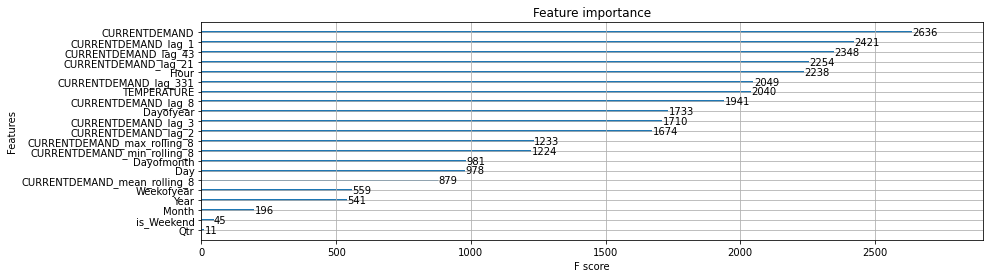

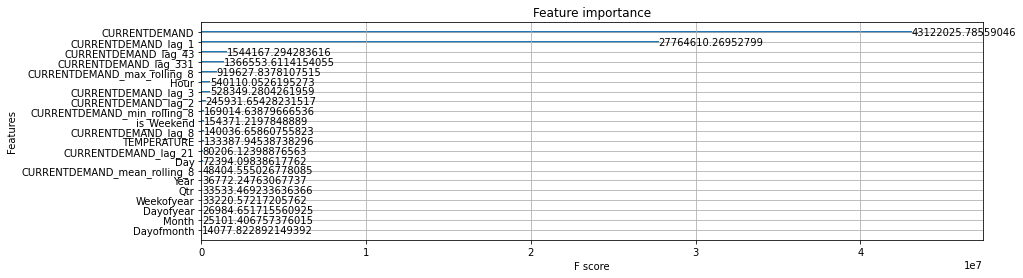

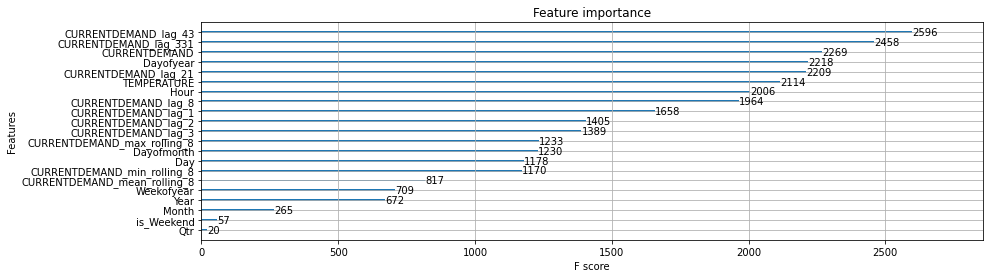

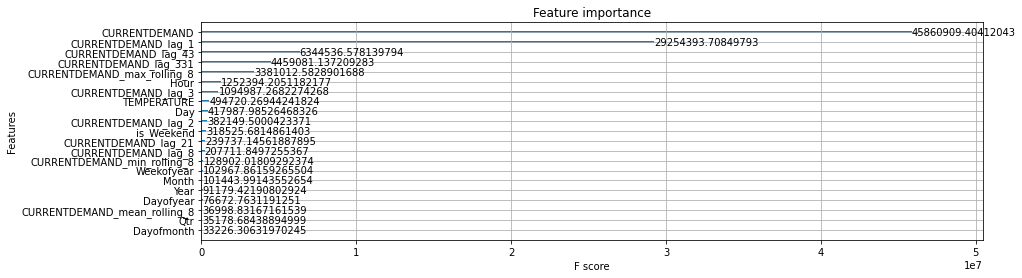

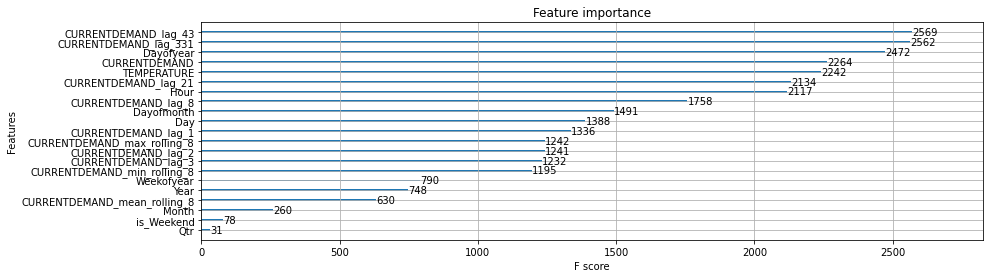

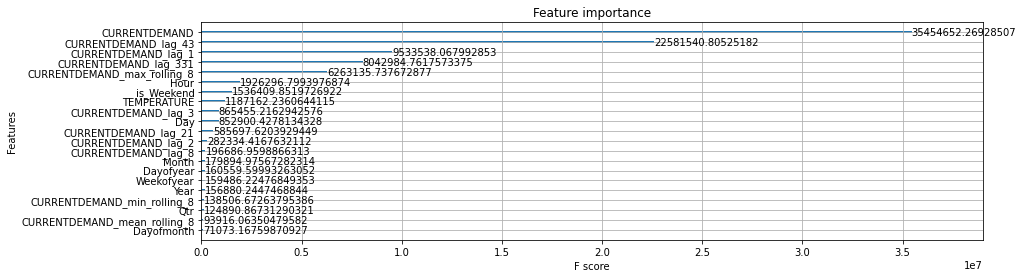

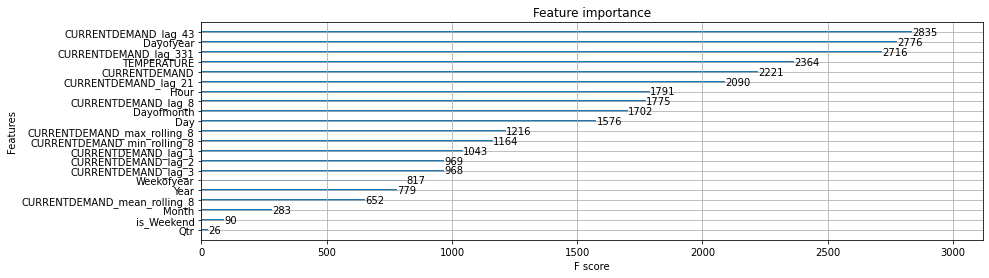

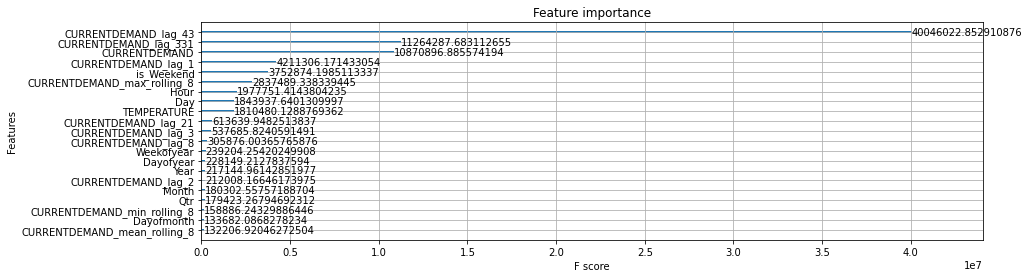

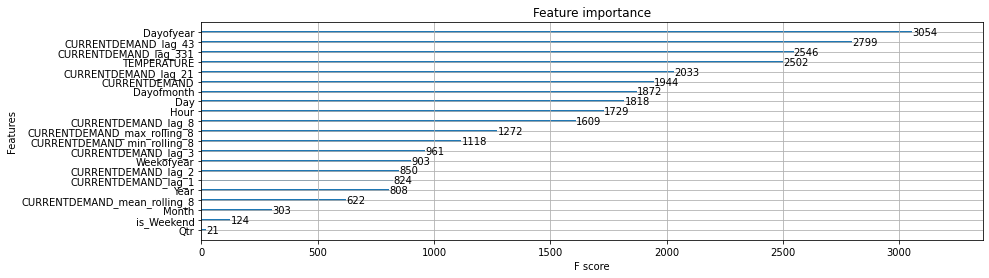

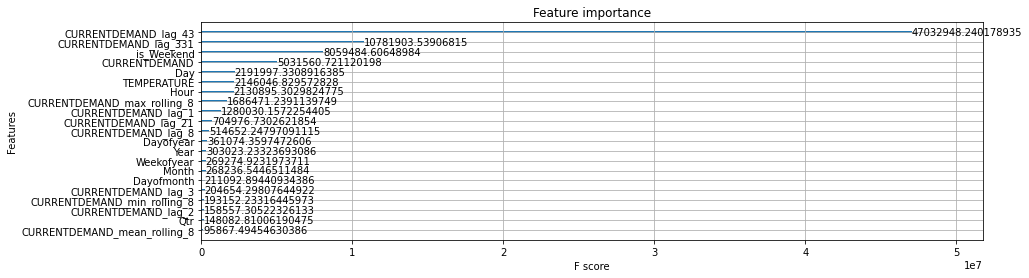

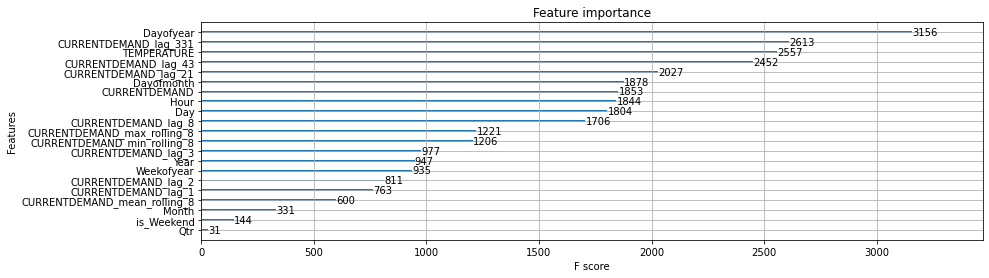

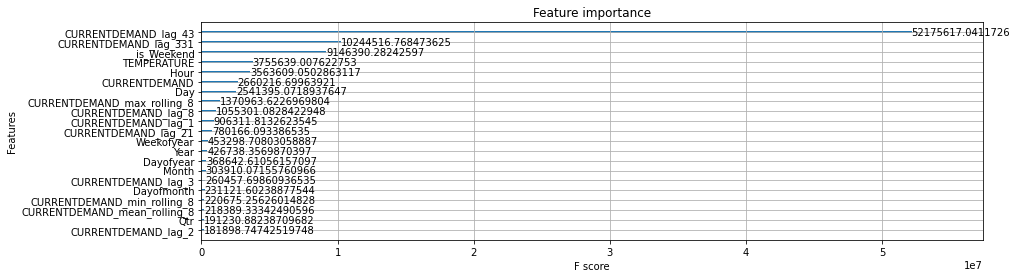

In [ ]:
# Get average feature importances:

# get cols names
colnames = list(X_train)
print(colnames)
# Access feature importances of models within multi regressor:
for model in XGB_Reg_1620.estimators_:
  #print(model)
  #print("Weight")
  plot_importance(model, importance_type="weight")
  #print("Gain")
  plot_importance(model, importance_type="gain")
  #print("Cover")
  #plot_importance(model, importance_type="cover")

# Evaluate on holdout set

Now that the model is trained and we have determined hyperparameter settings, we ca do a final evaluation on the final test (holdout) set.
This will inform us if the model generalises well to unseen data. 
First we prepeare out holdout set in the same way we prepared our train and test sets above.

Before this is done, the model is trained on the training data plus what was previously used as the test / validation set (everything except final holdout set)
- it is important to note that parameters are not modified at this point to fit the final test set, as this would defeat the point of having a final holdout set.

In [ ]:
# train model on train plus test set with the same parameters used above. (holdout will be used as the test set for the final iteration).

# Concatenate previous train and test sets to make new training set
df_traintest = df_train_1620.append(df_test_1620)

# Set up features and target
X_train, y_train = prepare_Xy(df_traintest)
X_test,  y_test = prepare_Xy(df_holdout_1620)

In [ ]:

# train model on ALTERNATIVE SET plus test set with the same parameters used above. (holdout will be used as the test set for the final iteration).

# Concatenate previous train and test sets to make new training set
df_traintest_21 = df_train_1621

# Set up features and target
X_train_21, y_train_21 = prepare_Xy(df_traintest_21)
X_test_21,  y_test_21 = prepare_Xy(df_holdout_1621)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(69600, 21)
(17568, 21)
(69600, 6)
(17568, 6)


In [ ]:
X_train.tail()

,TEMPERATURE,Hour,Day,Month,Year,Qtr,Dayofyear,Dayofmonth,Weekofyear,CURRENTDEMAND,is_Weekend,CURRENTDEMAND_lag_1,CURRENTDEMAND_lag_2,CURRENTDEMAND_lag_3,CURRENTDEMAND_lag_8,CURRENTDEMAND_lag_21,CURRENTDEMAND_lag_43,CURRENTDEMAND_lag_331,CURRENTDEMAND_mean_rolling_8,CURRENTDEMAND_max_rolling_8,CURRENTDEMAND_min_rolling_8
DATETIME,,,,,,,,,,,,,,,,,,,,,
2019-12-31 21:30:00,23.7,21,1,12,2019,4,365,31,1,6935.88,0,7013.18,7224.69,7314.78,7654.19,6080.10,6173.98,6008.01,7317.24125,7666.14,6935.88
2019-12-31 22:00:00,24.3,22,1,12,2019,4,365,31,1,6769.25,0,6935.88,7013.18,7224.69,7666.14,6076.48,6045.26,5832.80,7205.13000,7494.64,6769.25
2019-12-31 22:30:00,23.8,22,1,12,2019,4,365,31,1,6716.85,0,6769.25,6935.88,7013.18,7494.64,6093.88,5871.45,5672.80,7107.90625,7483.69,6716.85
2019-12-31 23:00:00,24.3,23,1,12,2019,4,365,31,1,6614.27,0,6716.85,6769.25,6935.88,7483.69,6125.51,5783.25,5554.89,6999.22875,7404.93,6614.27
2019-12-31 23:30:00,24.2,23,1,12,2019,4,365,31,1,6432.74,0,6614.27,6716.85,6769.25,7404.93,6221.40,5670.18,5451.32,6877.70500,7314.78,6432.74


In [ ]:
X_test.tail()

,TEMPERATURE,Hour,Day,Month,Year,Qtr,Dayofyear,Dayofmonth,Weekofyear,CURRENTDEMAND,is_Weekend,CURRENTDEMAND_lag_1,CURRENTDEMAND_lag_2,CURRENTDEMAND_lag_3,CURRENTDEMAND_lag_8,CURRENTDEMAND_lag_21,CURRENTDEMAND_lag_43,CURRENTDEMAND_lag_331,CURRENTDEMAND_mean_rolling_8,CURRENTDEMAND_max_rolling_8,CURRENTDEMAND_min_rolling_8
DATETIME,,,,,,,,,,,,,,,,,,,,,
2020-12-31 21:30:00,23.3,21,3,12,2020,4,366,31,53,6747.15,0,6869.49,7089.67,7205.22,7280.80,5748.60,5994.99,6039.04,7129.84125,7326.36,6747.15
2020-12-31 22:00:00,23.1,22,3,12,2020,4,366,31,53,6653.52,0,6747.15,6869.49,7089.67,7326.36,5878.42,5843.06,5831.29,7045.73625,7304.66,6653.52
2020-12-31 22:30:00,22.8,22,3,12,2020,4,366,31,53,6576.88,0,6653.52,6747.15,6869.49,7256.47,5964.19,5712.82,5643.97,6960.78750,7304.66,6576.88
2020-12-31 23:00:00,22.7,23,3,12,2020,4,366,31,53,6517.72,0,6576.88,6653.52,6747.15,7304.66,5995.44,5629.04,5546.77,6862.42000,7239.71,6517.72
2020-12-31 23:30:00,22.7,23,3,12,2020,4,366,31,53,6357.55,0,6517.72,6576.88,6653.52,7239.71,6038.08,5580.31,5482.98,6752.15000,7205.22,6357.55


## Train final model and Evaluate on holdout set
- train ofinal mode on train+validation set 
- test on holdout set (Jan 2020 - Mar 2021)

In [ ]:
# Initialise model:
XGB_multi_final = MultiOutputRegressor(XGB_Reg_tuned)

# fit multi output regressor
XGB_multi_final.fit(X_train, y_train)

[11:02:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:02:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:03:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


MultiOutputRegressor(estimator=XGBRegressor(colsample_bytree=0.7980169531492971,
                                            gamma=2.8712586599888503,
                                            max_depth=5, min_child_weight=4,
                                            n_estimators=1000, reg_alpha=177,
                                            reg_lambda=0.022218633053579184,
                                            seed=42, tree_method='hist'))

In [ ]:
# Define function to calculate metrics on holdout set
def evaluate_holdout(model, df_holdout):
  X_holdout, y_holdout = prepare_Xy(df_holdout)
  y_pred = model.predict(X_holdout)
  mse, rmse, mae, mape, r2, acc = calc_evaluation_metrics(y_pred, y_holdout, "Holdout Set")
  d = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R-Squared': r2, 'Accuracy': acc}
  metrics = pd.Series(data=d)
  return metrics, y_pred

# Calculate metrics for final train
metrics_final, y_pred_final = evaluate_holdout(XGB_multi_final, df_holdout_1620)

Evaluation Metrics of Holdout Set
Mean Squared Error : 20171.17108682
Root Mean Squared Error : 142.02524806
Mean Absolute Error : 95.68226420
Mean Absolute Percentage Error : 0.01592907
R-Squared : 0.97794896%
Accuracy: 98.40709334%.


- Results on holdout set are quite good and sufficient. MSE is a bit higher than during training, which could be an indication of slight overfitting and could be further tuned with a greater time budget.
- The next step is to compare this to our benchmark i.e. the historical forecast demand. This will tell us if our result is a good one.

### Evaluate on alternative holdout set 
(Mar 2020 - Mar 2021)
- The above resutls coult then be improved by training the model on more recent data. A production model would be trained on the most recent data available.
- Below method uses more recent data while still being trained on a year's worth of data
- This was not used in the above model so as to be using the same time peroid in each fold of validation.

In [ ]:
# Initialise model:
XGB_multi_final_alt = MultiOutputRegressor(XGB_Reg_tuned)

# fit multi output regressor
XGB_multi_final_alt.fit(X_train_21, y_train_21)

[10:27:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:27:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:28:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


MultiOutputRegressor(estimator=XGBRegressor(colsample_bytree=0.7980169531492971,
                                            gamma=2.8712586599888503,
                                            max_depth=5, min_child_weight=4,
                                            n_estimators=1000, reg_alpha=177,
                                            reg_lambda=0.022218633053579184,
                                            seed=42, tree_method='hist'))

In [ ]:
# Define function to calculate metrics on holdout set
def evaluate_holdout(model, df_holdout):
  X_holdout, y_holdout = prepare_Xy(df_holdout)
  y_pred = model.predict(X_holdout)
  mse, rmse, mae, mape, r2, acc = calc_evaluation_metrics(y_pred, y_holdout, "Holdout Set")
  d = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R-Squared': r2, 'Accuracy': acc}
  metrics = pd.Series(data=d)
  return metrics, y_pred

# Calculate metrics for final train - alternative seta
metrics_final_alt, y_pred_alt = evaluate_holdout(XGB_multi_final_alt, df_holdout_1621)

Evaluation Metrics of Holdout Set
Mean Squared Error : 17967.83088911
Root Mean Squared Error : 134.04413784
Mean Absolute Error : 90.65539845
Mean Absolute Percentage Error : 0.01454038
R-Squared : 0.9782608%
Accuracy: 98.54596208%.


# Plot predictions against actuals

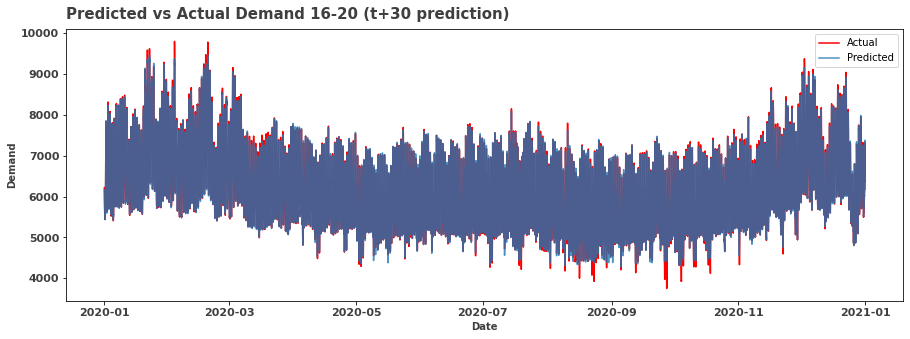

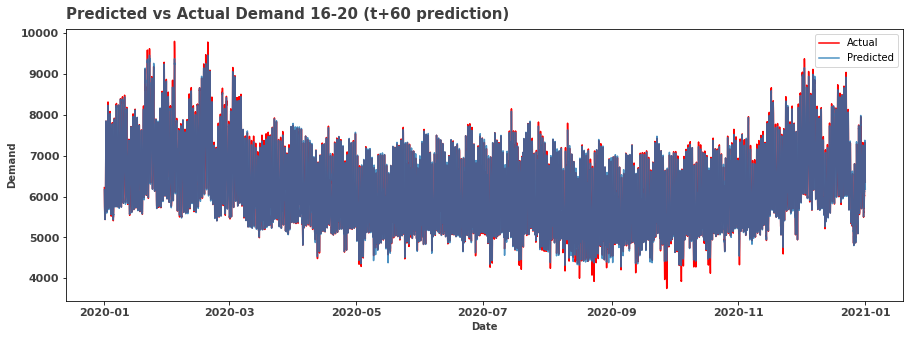

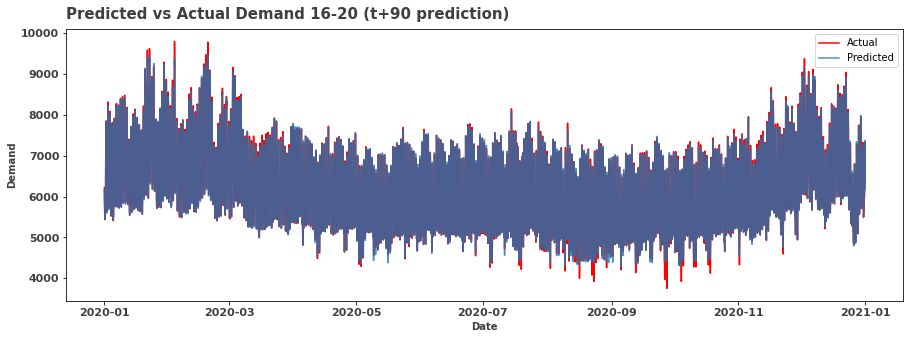

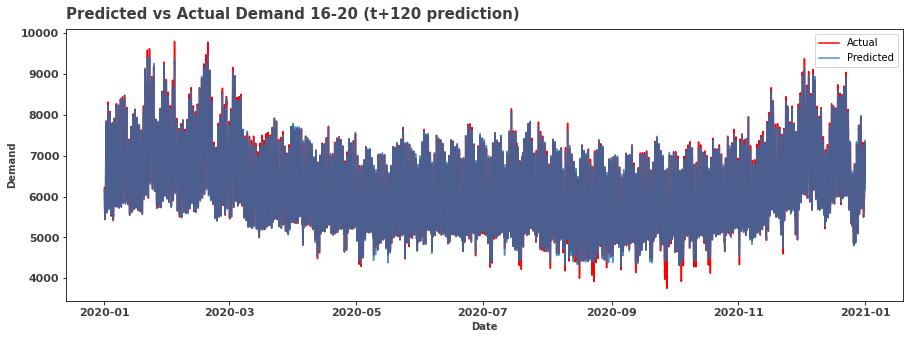

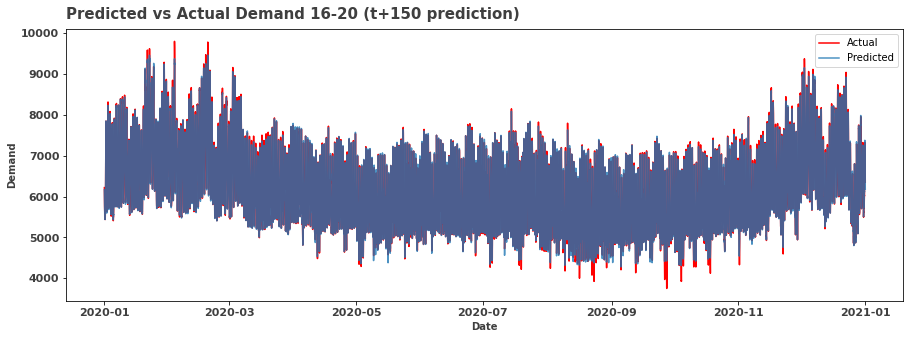

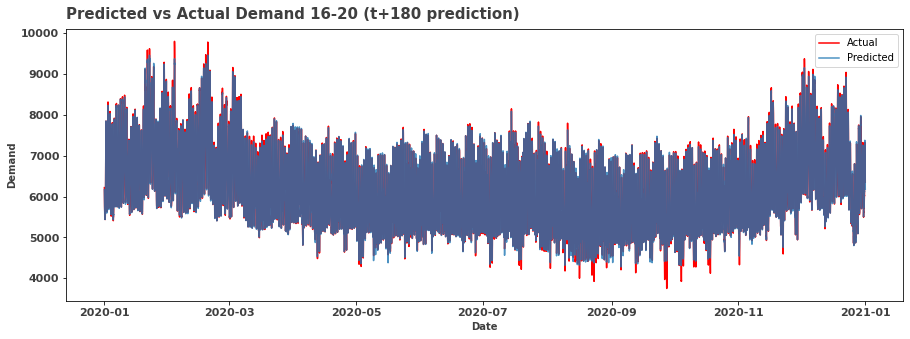

In [ ]:
# Plot predictions against actuals
def plot_single_prediction(actual, predicted, title):
  fig, ax= plt.subplots(figsize=(15,5))

  ax.plot(actual.index, actual["TOTALDEMAND"], label="Actual", color='red')
  ax.plot(actual.index, predicted, alpha=0.8, zorder=10, label="Predicted")
  plt.xlabel("Date", alpha=0.75, weight="bold")
  plt.ylabel("Demand", alpha=0.75, weight="bold")
  plt.xticks(alpha=0.75,weight="bold", fontsize=11)
  plt.yticks(alpha=0.75,weight="bold", fontsize=11)
  plt.title(title, alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
  plt.legend()

def plot_predictions(model, demand_train, demand_test, y_pred, title):
  plot_single_prediction(demand_test, y_pred[:,0], title + str(" (t+30 prediction)"))
  plot_single_prediction(demand_test, y_pred[:,0], title + str(" (t+60 prediction)"))
  plot_single_prediction(demand_test, y_pred[:,0], title + str(" (t+90 prediction)"))
  plot_single_prediction(demand_test, y_pred[:,0], title + str(" (t+120 prediction)"))
  plot_single_prediction(demand_test, y_pred[:,0], title + str(" (t+150 prediction)"))
  plot_single_prediction(demand_test, y_pred[:,0], title + str(" (t+180 prediction)"))

# Plot predictions for the three years
plot_predictions(XGB_multi_final, df_traintest, df_holdout_1620, y_pred_final, "Predicted vs Actual Demand 16-20")

# Look at periods of time with best and worst predictions

In [ ]:
# Worst Hour Prediction for t+30 predicion only
df_holdout_1620["Difference"] = np.abs(df_holdout_1620["TOTALDEMAND"] - y_pred_final[:,0])
df_holdout_1620["Difference"].sort_values(ascending=False)[:10]

DATETIME
2020-09-27 14:00:00    827.779687
2020-09-27 13:00:00    820.759102
2020-09-27 13:30:00    818.324590
2020-09-27 14:30:00    774.853789
2020-08-23 13:30:00    737.472949
2020-09-26 13:30:00    728.091328
2020-02-19 20:00:00    725.665117
2020-09-26 14:00:00    717.043379
2020-09-27 12:00:00    713.826406
2020-09-27 12:30:00    712.953594
Name: Difference, dtype: float64

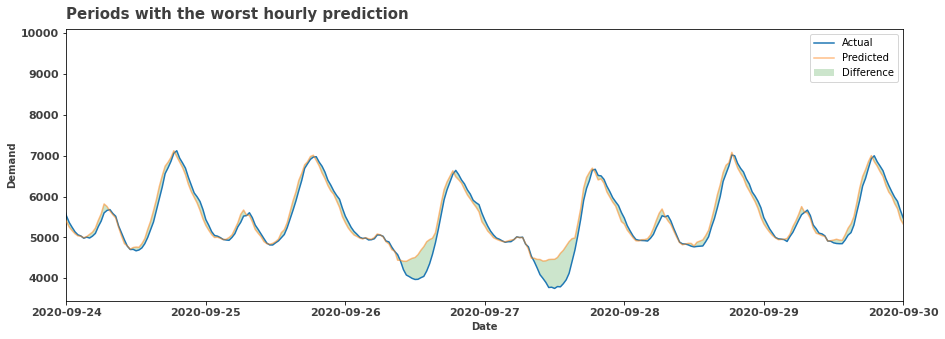

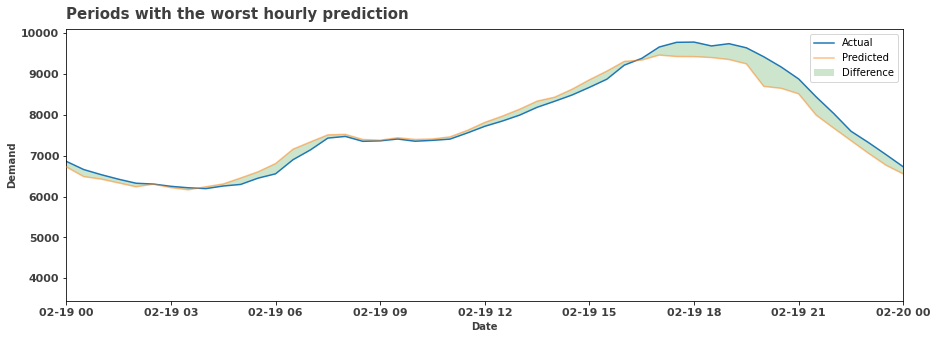

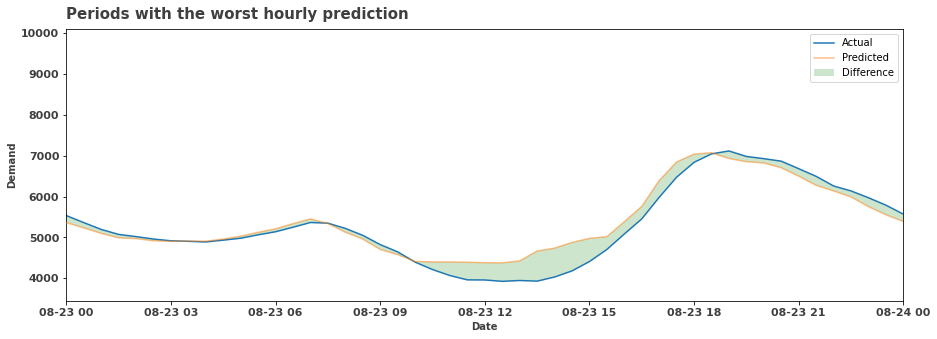

In [ ]:
def plot_specific_period(df_holdout, y_pred, t, date_start, date_end, title):
  fig, ax= plt.subplots(figsize=(15,5))

  ax.plot(df_holdout.index, df_holdout["TOTALDEMAND"], label="Actual")
  ax.plot(df_holdout.index, y_pred[:,t],alpha=.5,zorder=10,label="Predicted")

  demand = df_holdout["TOTALDEMAND"]
  pred = y_pred[:,0]

  plt.fill_between(df_holdout.index, demand, pred, facecolor="green", alpha=.2, label="Difference")

  # Set axes to look at specified interval

  #ax.set_ylim()
  ax.set_xbound(lower=date_start, upper=date_end)

  plt.xlabel("Date", alpha=0.75, weight="bold")
  plt.ylabel("Demand", alpha=0.75, weight="bold")

  plt.xticks(alpha=0.75,weight="bold", fontsize=11)
  plt.yticks(alpha=0.75,weight="bold", fontsize=11)

  plt.title(title, alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
  plt.legend()

plot_specific_period(df_holdout_1620, y_pred_final, 0, datetime.date(2020, 9, 24), datetime.date(2020, 9, 30), "Periods with the worst hourly prediction")
plot_specific_period(df_holdout_1620, y_pred_final, 0, datetime.date(2020, 2, 19), datetime.date(2020, 2, 20), "Periods with the worst hourly prediction")
plot_specific_period(df_holdout_1620, y_pred_final, 0, datetime.date(2020, 8, 23), datetime.date(2020, 8, 24), "Periods with the worst hourly prediction")


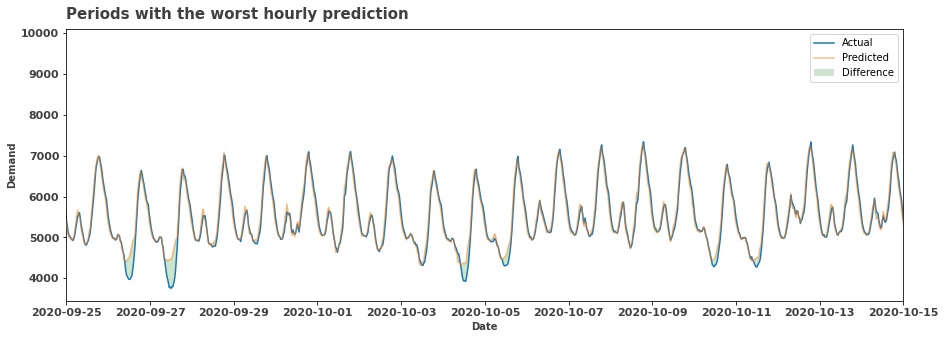

In [ ]:


plot_specific_period(df_holdout_1620, y_pred_final, 0, datetime.date(2020, 9, 25), datetime.date(2020, 10, 15), "Periods with the worst hourly prediction")

In [ ]:
# Worst Days
worst_days = df_holdout_1620.groupby(['Year',"Month",'Dayofmonth']).mean()[['TOTALDEMAND', 'Difference']]
worst_days.sort_values(by="Difference", ascending=False)[:10]

TOTALDEMAND  Difference
Year Month Dayofmonth                         
2020 9     27          5050.866042  246.809232
     8     23          5279.824167  209.208523
     7     14          6202.437500  199.437492
     9     26          5142.316458  197.201832
     6     24          6102.497292  194.272999
     7     15          6068.149583  193.914968
     6     25          6078.688750  189.728008
     7     16          5982.803333  187.234773
     6     23          6070.556875  186.519976
     7     17          5958.832500  186.439165

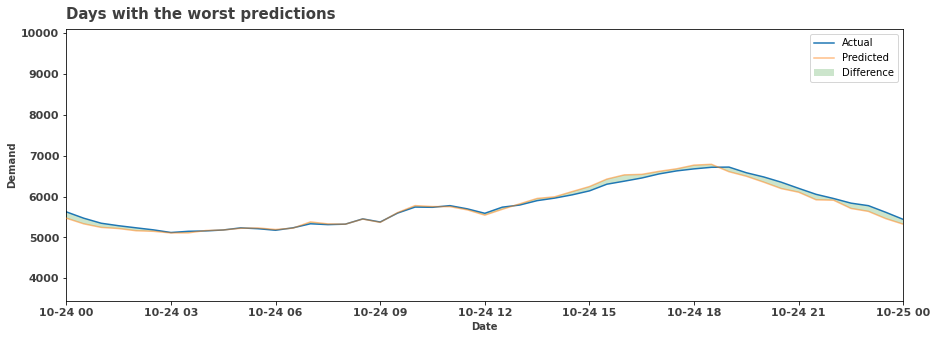

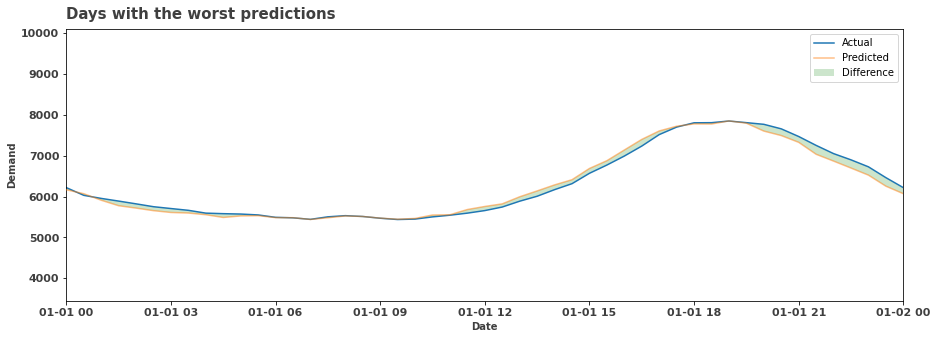

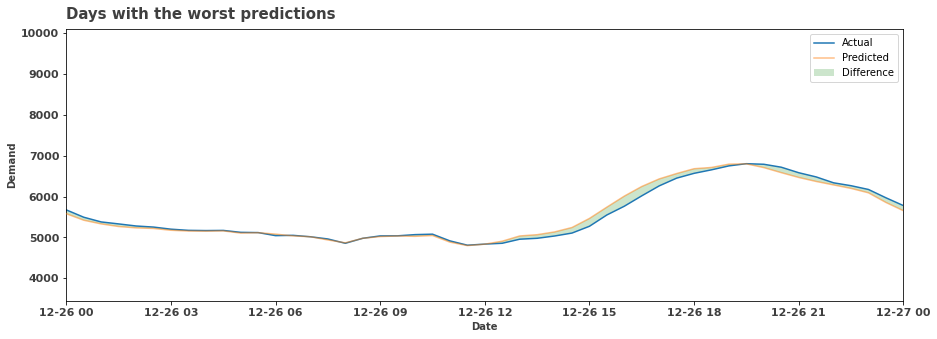

In [ ]:
# Plot best days
plot_specific_period(df_holdout_1620, y_pred_final, 0, datetime.date(2020, 10, 24), datetime.date(2020, 10, 25), "Days with the worst predictions")
plot_specific_period(df_holdout_1620, y_pred_final, 0, datetime.date(2020, 1, 1), datetime.date(2020, 1, 2), "Days with the worst predictions")
plot_specific_period(df_holdout_1620, y_pred_final, 0, datetime.date(2020, 12, 26), datetime.date(2020, 12, 27), "Days with the worst predictions")

In [ ]:
# Best Days
worst_days.sort_values(by="Difference",ascending=True)[:10]

TOTALDEMAND  Difference
Year Month Dayofmonth                         
2020 12    30          6467.655417   60.798764
     10    24          5778.700000   64.495942
     12    26          5549.013125   67.491385
           12          6016.805208   69.637238
     10    31          5914.109792   69.762264
     4     18          5943.813125   70.331216
     1     25          7005.274792   70.766006
     12    24          6391.643958   70.796694
           11          6644.075833   70.877188
     2     23          6178.341250   71.228682

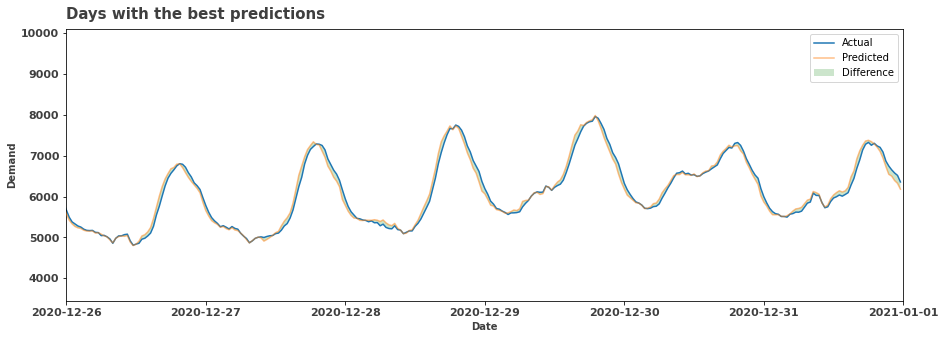

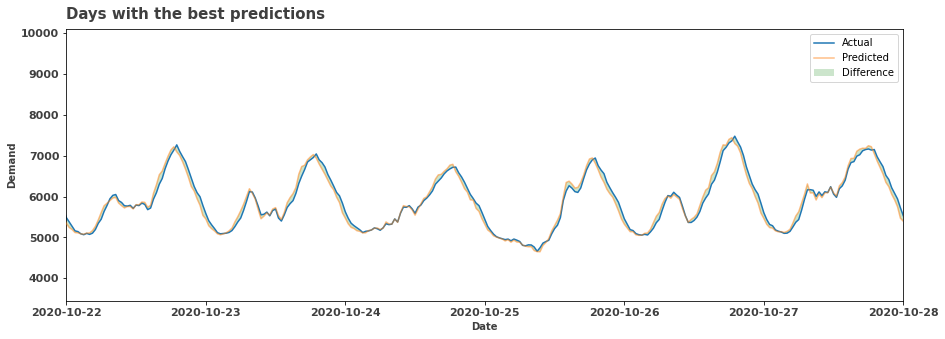

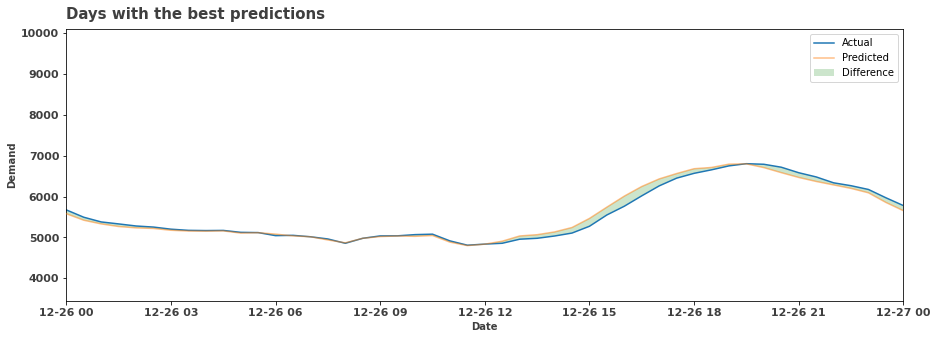

In [ ]:
# Plot best days
plot_specific_period(df_holdout_1620, y_pred_final, 0, datetime.date(2020, 12, 26), datetime.date(2021, 1, 1), "Days with the best predictions")
plot_specific_period(df_holdout_1620, y_pred_final, 0, datetime.date(2020, 10, 22), datetime.date(2020, 10, 28), "Days with the best predictions")
plot_specific_period(df_holdout_1620, y_pred_final, 0, datetime.date(2020, 12, 26), datetime.date(2020, 12, 27), "Days with the best predictions")

## Investigate errors

In [ ]:
df_preds = pd.DataFrame(y_pred_final, columns = ['F_DEMAND_30','TOTALDEMAND_60','TOTALDEMAND_90', "TOTALDEMAND_120", "TOTALDEMAND_150", "TOTALDEMAND_180"])

In [ ]:
df_pred_error = 

In [ ]:
df_pred_error = pd.concat([df_pred_error, df_holdout_1620["TEMPERATURE"]], axis=1)

In [ ]:
df_pred_error2.tail()

,F_DEMAND_30,TOTALDEMAND_60,TOTALDEMAND_90,TOTALDEMAND_120,TOTALDEMAND_150,TOTALDEMAND_180,TEMPERATURE
2020-12-31 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,23.3
2020-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,23.1
2020-12-31 22:30:00,NaN,NaN,NaN,NaN,NaN,NaN,22.8
2020-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,22.7
2020-12-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,22.7


In [ ]:
df_holdout_1620.head()

,TEMPERATURE,TOTALDEMAND,Hour,Day,Month,Year,Qtr,Dayofyear,Dayofmonth,Weekofyear,CURRENTDEMAND,TOTALDEMAND_30,TOTALDEMAND_60,TOTALDEMAND_90,TOTALDEMAND_120,TOTALDEMAND_150,TOTALDEMAND_180,is_Weekend,CURRENTDEMAND_lag_1,CURRENTDEMAND_lag_2,CURRENTDEMAND_lag_3,CURRENTDEMAND_lag_8,CURRENTDEMAND_lag_21,CURRENTDEMAND_lag_43,CURRENTDEMAND_lag_331,CURRENTDEMAND_mean_rolling_8,CURRENTDEMAND_max_rolling_8,CURRENTDEMAND_min_rolling_8
DATETIME,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,24.3,6218.39,0,2,1,2020,1,1,1,1,6218.39,6029.36,5954.32,5888.68,5820.63,5750.66,5705.83,0,NaN,5752.605601,5752.605601,5752.605601,5752.605601,5752.605601,5752.605601,5752.605601,5752.605601,5752.605601
2020-01-01 00:30:00,24.0,6029.36,0,2,1,2020,1,1,1,1,6029.36,5954.32,5888.68,5820.63,5750.66,5705.83,5662.17,0,6218.39,5752.605601,5752.605601,5752.605601,5752.605601,5752.605601,5752.605601,5752.605601,5752.605601,5752.605601
2020-01-01 01:00:00,23.5,5954.32,1,2,1,2020,1,1,1,1,5954.32,5888.68,5820.63,5750.66,5705.83,5662.17,5593.15,0,6029.36,6218.390000,5485.280041,5485.280041,5485.280041,5485.280041,5485.280041,5485.280041,5485.280041,5485.280041
2020-01-01 01:30:00,23.3,5888.68,1,2,1,2020,1,1,1,1,5888.68,5820.63,5750.66,5705.83,5662.17,5593.15,5580.14,0,5954.32,6029.360000,6218.390000,5485.280041,5485.280041,5485.280041,5485.280041,5485.280041,5485.280041,5485.280041
2020-01-01 02:00:00,23.5,5820.63,2,2,1,2020,1,1,1,1,5820.63,5750.66,5705.83,5662.17,5593.15,5580.14,5570.90,0,5888.68,5954.320000,6029.360000,5349.016790,5349.016790,5349.016790,5349.016790,5349.016790,5349.016790,5349.016790
